# Summarize GPS information in a regular grid

<p style='padding:8px'>This functionality of tracklib reduce the full dataset of GPS traces into a regular grid of summarized features. In each cell, <i>n</i> aggregated features (such as mean and standard deviation of speeds, number of traces, most frequent bearing ...) are computed to produce a set of raster maps, which may be seen as a single image with <i>n</i> channels.</p>

<p style='padding:8px'>These process has been used in works presented in (1).</p>

<figure style='text-align:center'>
<img src="summarize3.png"  width="650" />
<figcaption><br/>Figure 1 : Workflow presented in (1) to produce raster images (5 meter-resolution grid)</figcaption>
</figure>

<div class="alert alert-block alert-info">
<b>Reference:</b><br/>(1) - Y. Méneroux and al. Convolutional Neural Network for Traffic Signal Inference based on GPS Traces. Proceedings of Spatial big data and machine learning in GIScience Workshop'18, August 28-31, 2018, Melbourne, Australia. GIScience.</div>



## Import de la librairie tracklib

Il faut importer tracklib si la librairie n'est pas dans le python path

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tracklib as trk

## Chargement du jeu de traces

The dataset comprises a set of 11862 GPS traces, located in Mitaka city (16 km2), suburbs of Tokyo (Japan).

In [2]:
PATH = '../../../../../PROJET/FINI/MITAKA/DATA/mitaka/complet'
trk.ObsTime.setReadFormat("4Y-2M-2D 2h:2m:2s")
param = trk.TrackFormat({
    'ext': 'CSV',
    'id_E':2, 
    'id_N':3, 
    'id_T':1
})
collection = trk.TrackReader.readFromFile(PATH, param)
print ('Number of tracks: ' + str(collection.size()))

Number of tracks: 11872


## Sélection des traces sur une zone restreinte de type Rectangle

Number of tracks: 3850


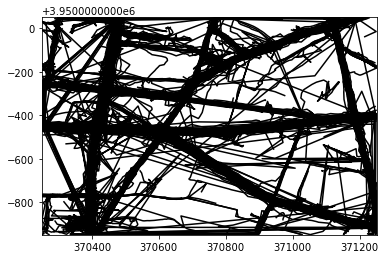

Number of tracks: 3802


In [3]:
import matplotlib.pyplot as plt

Xmin = 370250
Xmax = 371250
Ymin = 3949050
Ymax = 3950050

ll = trk.ENUCoords(Xmin, Ymin)
ur = trk.ENUCoords(Xmax, Ymax)
bbox = trk.Rectangle(ll, ur)

constraintBBox = trk.Constraint(shape = bbox, mode = trk.MODE_INSIDE, type=trk.TYPE_CUT_AND_SELECT)
selections = constraintBBox.select(collection)
print ('Number of tracks: ' + str(selections.size()))

for track in selections:
    if track.size() < 10:
        selections.removeTrack(track)
selections.plot('k')

plt.xlim((Xmin, Xmax))
plt.ylim((Ymin, Ymax))
plt.show()

print ('Number of tracks: ' + str(selections.size()))
collection = selections

## Raster de la moyenne des vitesses et de l'orientation de la plus fréquente par cellule

Les AF seront calculées si elles n'ont pas encore été créées

Les scripts des deux AF qu'on prend existent déjà dans la librairie, sinon il aurait fallu les écrire

In [4]:
# On crée l'AF speed
collection.addAnalyticalFeature(trk.speed)
collection.addAnalyticalFeature(trk.orientation)

af_algos = [trk.speed, trk.orientation]
cell_operators = [trk.co_avg, trk.co_dominant]  

marge = 0
resolution = (5, 5)
raster = trk.summarize(collection, af_algos, cell_operators, resolution, marge)

## Conversion des indicateurs en 8-bit grayscale 

Feature values are converted on a 8-bit grayscale.

In [5]:
# the mean of speeds is distributed between 16 and 255
mapAvgSpeed = raster.getAFMap('speed#co_avg')
for i in range(raster.nrow):
    for j in range(raster.ncol):
        val = mapAvgSpeed.grid[i][j]
        if val != raster.getNoDataValue():
            if val > 25:
                mapAvgSpeed.grid[i][j] = 10
            else:
                mapAvgSpeed.grid[i][j] = 100 - val/25*90

# The dominance of orientations is discretized in 8 eight values
mapDominantOrientation = raster.getAFMap('orientation#co_dominant')
for i in range(raster.nrow):
    for j in range(raster.ncol):
        val = mapDominantOrientation.grid[i][j]
        if val != raster.getNoDataValue():
            if val == 1:
                mapDominantOrientation.grid[i][j] = 156
            elif val == 2:
                mapDominantOrientation.grid[i][j] = 218
            elif val == 3:
                mapDominantOrientation.grid[i][j] = 249
            elif val == 4:
                mapDominantOrientation.grid[i][j] = 187
            elif val == 5:
                mapDominantOrientation.grid[i][j] = 125
            elif val == 6:
                mapDominantOrientation.grid[i][j] = 63
            elif val == 7:
                mapDominantOrientation.grid[i][j] = 32
            elif val == 8:
                mapDominantOrientation.grid[i][j] = 94
            else:
                mapDominantOrientation.grid[i][j] = 0

## Affichage

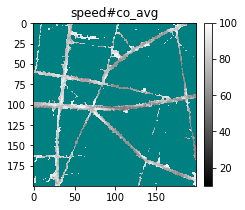

In [6]:
import matplotlib.pyplot as plt

# make an image, just to create the icon for the use case gallery
mapAvgSpeed.plotAsImage(novaluecolor='teal')
plt.show()

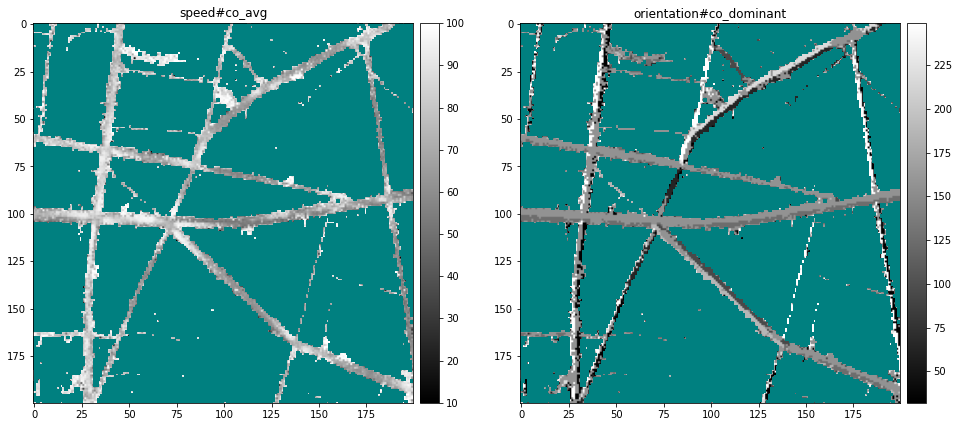

In [7]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
mapAvgSpeed.plotAsImage(ax1, novaluecolor='teal')

ax2 = fig.add_subplot(122)
mapDominantOrientation.plotAsImage(ax2, novaluecolor='teal')
print ('')